# README
* If you are running this for the first time in Google Colab, you may need to run the pip install for streamlit to be on the safer side (it has been commented out below). However, if this is being run on Jupyter Notebook and you've already installed streamlit via Terminal/Command Prompt them you're good to go.

In [1]:
#!pip install transformers torch
#!pip install tkinter
#!pip install streamlit
#!pip install tf-keras
#!pip install torch
#!pip install accelerate -U
#!pip install transformers\[torch\] accelerate -U
#!pip install 'transformers[torch]' accelerate -U
#!pip install datasets

In [2]:
import transformers
import accelerate

print(transformers.__version__)
print(accelerate.__version__)

4.42.4
0.32.1


In [3]:
import os
import streamlit as st
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM, Trainer, TrainingArguments, EarlyStoppingCallback, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import random
import nltk
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from datasets import load_dataset

# Limitations that had to be addressed
* Due to the fact that Colab limits the amount of RAM users have access to at any given time, we had to use a few crafty workaround in order for the program to load our large dataset (such as enable GPU acceleration, splitting the dataset into chunks, and processing them separately)

In [4]:
# GPU/TPU acceleration in Colab
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Dataset file uploader
# from google.colab import files
# uploaded = files.upload()

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
file_path = '/content/drive/MyDrive/twi-dataset.txt'  # Adjust path as necessary
df = pd.read_csv(file_path, delimiter='\t', header=None, names=['English', 'Twi'])

In [67]:
# Sample a smaller subset of the dataset (e.g., 10% of the data)
subset_fraction = 0.1  # Adjust the fraction as needed
subset_df = df.sample(frac=subset_fraction, random_state=42)

In [68]:
subset_df.head()

,English,Twi
383158,In displaying generosity Nehemiah set an outst...,Nehemia yɛɛ ayamye ho nhwɛso a ɛsen biara maa ...
82257,One day while in Eidelstedt I was reading from...,Da bi bere a na yɛwɔ Eidelstedt no na merekenk...
374539,The last book of the Bible identifies Jesus as...,Bible nhoma a etwa to no da no adi sɛ Yesu yɛ ...
299283,The unrelenting wind threatens the existence o...,Mframa a ano yɛ den a ɛbɔ bere nyinaa no haw a...
122119,The bottom line If you are experiencing proble...,Yɛbɛtwa no tiaa a sɛ worehyia ɔhaw wɔ w’awareɛ...


In [69]:
twi_sentences = subset_df['Twi'].tolist()

In [70]:
twi_only_path = '/content/twi_only_dataset.txt'

In [72]:
with open(twi_only_path, 'w') as file:
    for sentence in twi_sentences:
        file.write(sentence + '\n')  # Ensure each sentence is written on a new line

In [73]:
# Verify the content of the file
with open(twi_only_path, 'r') as file:
    content = file.read()
    print("Content of sampled_twi_dataset.txt:")
    print(content[:500])  # Print the first 500 characters to verify the content

Content of sampled_twi_dataset.txt:
Nehemia yɛɛ ayamye ho nhwɛso a ɛsen biara maa Onyankopɔn asomfo nyinaa .
Da bi bere a na yɛwɔ Eidelstedt no na merekenkan Bible akyerɛ mmea no mu kakraa bi .
Bible nhoma a etwa to no da no adi sɛ Yesu yɛ Onyankopɔn adebɔ mfiase . 
Mframa a ano yɛ den a ɛbɔ bere nyinaa no haw alpine nnua no denam wim hyew a ɛbrɛ no ase na ɛma mframa ne dɔte no mu yɛ wesee na etutu nnua no gu no so .
Yɛbɛtwa no tiaa a sɛ worehyia ɔhaw wɔ w’awareɛ mu a ɛnyɛ saa bere no na ɛsɛ sɛ woma w’adwenem yɛ wo naa .
Esiane sɛ


In [74]:
with open(twi_only_path, 'r') as file:
    num_lines = sum(1 for line in file)

print(f"The sampled Twi dataset contains {num_lines} lines.")

The sampled Twi dataset contains 59459 lines.


In [75]:
!wc -l /content/twi_only_dataset.txt

59459 /content/twi_only_dataset.txt


In [77]:
twi_df = pd.read_csv(twi_only_path, header=None, names=['Twi'])

In [12]:
# print(df.head())

In [13]:
# This is an example dataset to help fine tune GhanaNLP
# english_and_twi_data = {
#     "English": ["Hello", "How are you?", "I am fine", "What is your name?", "My name is John",
#                 "Where are you going?", "I am going to school", "I love you", "Thank you",
#                 "Good morning", "Good evening", "Good night", "Yes", "No", "Please", "Sorry"],
#     "Twi": ["Afehyia pa", "Wo ho te sɛn?", "Me ho yɛ", "Wo din de sɛn?", "Me din de John",
#             "Worekɔ he?", "Merekɔ sukuu", "Medɔ wo", "Medase", "Maakye", "Maadwo", "Da yie",
#             "Aane", "Dabi", "Mepa wo kyɛw", "Kosɛ"]
# }

In [14]:
# df = pd.DataFrame(english_and_twi_data)
# df.to_csv('twi_sentences.csv', index=False)

In [15]:
# df = pd.read_csv('twi_sentences.csv')

In [16]:
# train_df, test_df = train_test_split(df, test_size=0.1)

In [17]:
# train_sentences = train_df['English'].tolist()
# test_sentences = test_df['English'].tolist()

In [78]:
tokenizer = AutoTokenizer.from_pretrained('Ghana-NLP/robako-base-asante-twi-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/515 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/881k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/527k [00:00<?, ?B/s]

In [79]:
def tokenize_and_mask(sentences, tokenizer, max_length=128, mask_probability=0.15):
    encodings = tokenizer(sentences, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
    labels = encodings['input_ids'].clone()

    probability_matrix = torch.full(labels.shape, mask_probability)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100

    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    encodings['input_ids'][indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    indices_random = torch.bernoulli(torch.full(labels.shape, 0.1)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    encodings['input_ids'][indices_random] = random_words[indices_random]

    return encodings, labels

In [80]:
# train_encodings, train_labels = tokenize_and_mask(train_sentences, tokenizer)
# test_encodings, test_labels = tokenize_and_mask(test_sentences, tokenizer)

In [81]:
class CustomMaskedLM(AutoModelForMaskedLM):
    def __init__(self, config):
        super().__init__(config)
        self.dropout = nn.Dropout(p=0.1)  # Add dropout with 10% probability

    def forward(self, *args, **kwargs):
        outputs = super().forward(*args, **kwargs)
        outputs.logits = self.dropout(outputs.logits)
        return outputs

In [82]:
# Initialize the model
model = CustomMaskedLM.from_pretrained('Ghana-NLP/robako-base-asante-twi-uncased')
model.to(device)

pytorch_model.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of the model checkpoint at Ghana-NLP/robako-base-asante-twi-uncased were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [83]:
# Split the subset into training and test sets
train_df, test_df = train_test_split(twi_df, test_size=0.1, random_state=42)

In [84]:
train_path = '/content/train_twi_dataset.txt'
test_path = '/content/test_twi_dataset.txt'

In [85]:
train_df.to_csv(train_path, index=False, header=False)
test_df.to_csv(test_path, index=False, header=False)

In [86]:
# Verify the content of the train and test files
with open(train_path, 'r') as file:
    train_content = file.read()
    print("Content of train_twi_dataset.txt:")
    print(train_content[:500])  # Print the first 500 characters to verify the content

with open(test_path, 'r') as file:
    test_content = file.read()
    print("Content of test_twi_dataset.txt:")
    print(test_content[:500])  # Print the first 500 characters to verify the content

Content of train_twi_dataset.txt:
 a Dɛn na wɔhyɛɛ ho nkɔm wɔ Petro ?
Nea ɔyɛe yi nyinaa mfaso bi aba so anaa ?
Eyi mu no Mose srɛe sɛ Yehowa NW san w’akyi ɛno da bɛn ara ? Na ma wo nkoa ade nyɛ wo mmɔbɔ .
Anokwa Yosef atwa sa pa ama nokware Kristofo nyinaa !
Sɛ Kristoni biara kɔ mmirika boro nea mmara ma kwan sɛ ɔkɔ so a ɛnde na odi fɔ sɛ wamfa Kaesare de amma Kaesare . ’
Ɛwom sɛ wɔnsraa nguan foforo no mufo no de nanso wonya honhom kronkron no wɔ kwan foforo so .
Daniel yɛ mum nanso na ɔnnim mum kasa no papa .
Ayaresa
Ansa na 
Content of test_twi_dataset.txt:
Onyankopɔn Asɛm Bible no ho anisɔ ne emu nokware nimdeɛ ne ade titiriw nti a wɔyɛ saa .
Ɔkwan bɛn na wɔfaa so kuraa wɔn anigye mu ?
Nokwarem no nhoma asekyerɛ yɛ nnwuma pii a ɛboa ma yetumi ka asɛmpa no yiye no mu biako pɛ .
Wɔ ne mfe no mu no dɛn na ebinom a wɔyɛɛ wɔn ade te sɛ nea wɔada no adi wɔ Yesaia no yɛe ?
Na afoforo renyɛ wɔn a wɔsɛ na na ɛsɛ sɛ asomafo no poroporow wɔn nan ase tutuw di adanse tia ’ nnipa a wɔte saa no 

In [87]:
# Count the number of lines in the train and test datasets
num_train_lines = len(train_df)
num_test_lines = len(test_df)

In [88]:
print(f"The train dataset contains {num_train_lines} lines.")
print(f"The test dataset contains {num_test_lines} lines.")

The train dataset contains 53265 lines.
The test dataset contains 5919 lines.


In [90]:
train_sentences = train_df['Twi'].tolist()
test_sentences = test_df['Twi'].tolist()

In [91]:
# Tokenize and mask the data
train_encodings, train_labels = tokenize_and_mask(train_sentences, tokenizer)
test_encodings, test_labels = tokenize_and_mask(test_sentences, tokenizer)

In [92]:
# Debugging: Print shapes of encodings and labels
print("Train Encodings Shape:", train_encodings['input_ids'].shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Encodings Shape:", test_encodings['input_ids'].shape)
print("Test Labels Shape:", test_labels.shape)

Train Encodings Shape: torch.Size([53265, 128])
Train Labels Shape: torch.Size([53265, 128])
Test Encodings Shape: torch.Size([5919, 128])
Test Labels Shape: torch.Size([5919, 128])


In [93]:
class TwiDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {key: val.cpu() for key, val in encodings.items()}  # Ensure encodings are on CPU
        self.labels = labels.cpu()  # Ensure labels are on CPU

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [94]:
train_dataset = TwiDataset(train_encodings, train_labels)
test_dataset = TwiDataset(test_encodings, test_labels)

In [95]:
# Verify no NaNs in datasets
assert not np.any(np.isnan(train_dataset.encodings['input_ids'].numpy())), "Training data contains NaNs"
assert not np.any(np.isnan(test_dataset.encodings['input_ids'].numpy())), "Validation data contains NaNs"

In [96]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=1e-5,  # Further reduced learning rate
    per_device_train_batch_size=16,  # Smaller batch size
    per_device_eval_batch_size=16,  # Smaller batch size
    num_train_epochs=10,  # Increased number of epochs
    weight_decay=0.1,  # Increased weight decay for better regularization
    logging_dir='./logs',
    logging_steps=10,
    gradient_accumulation_steps=1,  # Use gradient accumulation to increase effective batch size
    max_grad_norm=1.0,
    load_best_model_at_end=True,
    save_strategy="epoch",
    save_total_limit=3,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [97]:
# Initializing the optimizer for training step
optimizer = torch.optim.AdamW(model.parameters(), lr=training_args.learning_rate)

In [98]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

In [99]:
# Extend the Trainer to store loss values
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr_scheduler = kwargs.pop("lr_scheduler", None)
        self.train_losses = []
        self.eval_losses = []

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        metrics = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)
        if self.lr_scheduler:
            self.lr_scheduler.step(metrics["eval_loss"])
        self.eval_losses.append(metrics["eval_loss"])
        return metrics

    def training_step(self, *args):
        loss = super().training_step(*args)
        self.train_losses.append(loss.item())
        return loss

In [100]:
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

In [101]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[early_stopping_callback],  # Pass the early stopping callback here
    optimizers=(optimizer, lr_scheduler)
)

In [102]:
# Debugging: Print training arguments and dataset sizes
print("Training Arguments:", training_args)
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(test_dataset))

Training Arguments: TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=epoch,
evaluation_strategy=epoch,
fp16=False,


In [103]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.764500,2.726852
2,2.483800,2.654101
3,2.484600,2.637644
4,1.837500,2.641052
5,1.845300,2.650404
6,1.746500,2.676069


There were missing keys in the checkpoint model loaded: ['lm_head.decoder.weight', 'lm_head.decoder.bias'].


TrainOutput(global_step=19980, training_loss=2.2981976468045193, metrics={'train_runtime': 3320.0158, 'train_samples_per_second': 160.436, 'train_steps_per_second': 10.03, 'total_flos': 1.059657663946752e+16, 'train_loss': 2.2981976468045193, 'epoch': 6.0})

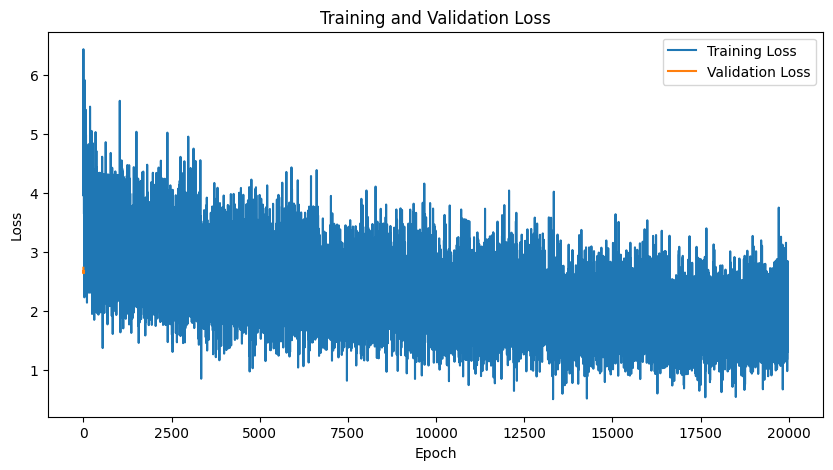

In [124]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(trainer.train_losses, label='Training Loss')
# plt.plot(range(len(trainer.eval_losses)), trainer.eval_losses, label='Validation Loss')
plt.plot(trainer.eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
# Saving the plot to a file
plt.savefig('training_validation_loss.png')

In [105]:
import math

In [106]:
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 13.98


In [107]:
model.save_pretrained('./fine-tuned-model')
tokenizer.save_pretrained('./fine-tuned-model')

('./fine-tuned-model/tokenizer_config.json',
 './fine-tuned-model/special_tokens_map.json',
 './fine-tuned-model/vocab.json',
 './fine-tuned-model/merges.txt',
 './fine-tuned-model/added_tokens.json',
 './fine-tuned-model/tokenizer.json')

In [108]:
# Load the fine-tuned model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('./fine-tuned-model')
model = AutoModelForMaskedLM.from_pretrained('./fine-tuned-model')

In [110]:
def load_model_and_tokenizer(model_dir='./fine-tuned-model'):
    if os.path.exists(model_dir):
        model = AutoModelForMaskedLM.from_pretrained(model_dir)
        tokenizer = AutoTokenizer.from_pretrained(model_dir)
        print(f"Loaded fine-tuned model from {model_dir}")
    else:
        model = AutoModelForMaskedLM.from_pretrained('Ghana-NLP/robako-base-asante-twi-uncased')
        tokenizer = AutoTokenizer.from_pretrained('Ghana-NLP/robako-base-asante-twi-uncased')
        print("Loaded base model and tokenizer")
    return model, tokenizer

In [111]:
# Load the model and tokenizer
model, tokenizer = load_model_and_tokenizer()

Loaded fine-tuned model from ./fine-tuned-model


In [116]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [117]:
def preprocess_sentence(sentence):
    sentence = sentence.strip()
    sentence = sentence.replace('3', 'ɛ').replace('3', 'Ɛ').replace('>', 'ɔ')
    return sentence

In [118]:
def predict_masked_word(masked_sentence, tokenizer, model, device='cpu'):
    mask_token = tokenizer.mask_token
    print(f"Mask token: {mask_token}")
    print(f"Input sentence: {masked_sentence}")

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(masked_sentence, return_tensors='pt')
    print(f"Tokenized inputs: {inputs}")

    mask_token_id = tokenizer.mask_token_id
    print(f"Mask token ID: {mask_token_id}")

    mask_token_index = torch.where(inputs["input_ids"] == mask_token_id)[1]
    print(f"Mask token indices: {mask_token_index}")

    if mask_token_index.size(0) == 0:
        raise ValueError(f"The input sentence must contain the {mask_token} token.")

    # Predict the masked token
    inputs = inputs.to(device)
    model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    mask_token_logits = logits[0, mask_token_index, :]
    top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

    predicted_words = [tokenizer.decode([token]).strip() for token in top_5_tokens]
    return predicted_words

In [119]:
model, tokenizer = load_model_and_tokenizer()  # Ensure model and tokenizer are loaded
masked_sentence = "Me kɔɔ <mask> anɔpa yi."
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predicted_words = predict_masked_word(masked_sentence, tokenizer, model, device)
print(f"Predicted words: {predicted_words}")

Loaded fine-tuned model from ./fine-tuned-model
Mask token: <mask>
Input sentence: Me kɔɔ <mask> anɔpa yi.
Tokenized inputs: {'input_ids': tensor([[   0,  956,  769,    4, 2368,  363,   18,    2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
Mask token ID: 4
Mask token indices: tensor([3])
Predicted words: ['asɛnka', 'saa', 'nhyiam', 'hɔ', 'so']


In [120]:
def check_sentence(sentence, tokenizer, model):
    sentence = preprocess_sentence(sentence)
    words = word_tokenize(sentence)
    corrected_words = []

    for word in words:
        if word in string.punctuation or word.isspace():
            corrected_words.append((word, None))
        elif word.isalpha():  # Check if the token is a word
            masked_sentence = sentence.replace(word, tokenizer.mask_token, 1)
            predicted_word = predict_masked_word(masked_sentence, tokenizer, model)

            if predicted_word and predicted_word != word:
                corrected_words.append((word, predicted_word))
            else:
                corrected_words.append((word, None))
        else:
            corrected_words.append((word, None))

    return corrected_words

In [121]:
def get_bot_response(user_input):
    corrected_words = check_sentence(user_input, tokenizer, model)

    if any(correction for _, correction in corrected_words):
        response = "I think there might be some improvements we can make to your sentence. Let's look at it together:\n\n"
        response += "<ul>"
        for original, correction in corrected_words:
            if correction:
                response += f"<li>'<strong>{original}</strong>' might be better as '<strong>{correction}</strong>'.</li>"
            elif original not in string.punctuation and not original.isspace():
                response += f"<li>'<strong>{original}</strong>' looks good!</li>"
        response += "</ul>"
        response += "\n\nCan you try writing the sentence again with these suggestions?"
    else:
        response = "Great job! Your sentence looks perfect to me. Would you like to try another one?"

    return response

# Downloading Fine-Trained Model
* This section was dedicated to getting the fine-tuned model extracted from the Colab environment

In [112]:
print(os.getcwd())

/content


In [113]:
!ls -l ./fine-tuned-model

total 329836
-rw-r--r-- 1 root root       734 Aug  5 11:50 config.json
-rw-r--r-- 1 root root    526963 Aug  5 11:50 merges.txt
-rw-r--r-- 1 root root 334030264 Aug  5 11:50 model.safetensors
-rw-r--r-- 1 root root       958 Aug  5 11:50 special_tokens_map.json
-rw-r--r-- 1 root root      1239 Aug  5 11:50 tokenizer_config.json
-rw-r--r-- 1 root root   2291377 Aug  5 11:50 tokenizer.json
-rw-r--r-- 1 root root    880805 Aug  5 11:50 vocab.json


In [114]:
import shutil
from google.colab import files

In [122]:
shutil.make_archive('fine-tuned-model', 'zip', './fine-tuned-model')

'/content/fine-tuned-model.zip'

In [123]:
files.download('fine-tuned-model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Streamlit Integration
Because of how we want children to directly interact with the program, we decided to lean into making it a "chatbot" of sorts which would step through the sentences and effectively be a word suggester

In [ ]:
st.title("Kasa Twi Nu! - A Twi Learning Chatbot")
st.write("Hello! I'm here to help you write out Twi sentences better. Type a sentence, and I'll help you improve it.")

In [ ]:
# Initialize chat history
if 'messages' not in st.session_state:
    st.session_state.messages = []

In [ ]:
# Display chat messages from history on app rerun
for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.markdown(message["content"])

In [ ]:
# React to user input
if prompt := st.chat_input("What's your sentence?"):
    # Display user message in chat message container
    st.chat_message("user").markdown(prompt)
    # Add user message to chat history
    st.session_state.messages.append({"role": "user", "content": prompt})

    response = get_bot_response(prompt)

    # Display assistant response in chat message container
    with st.chat_message("assistant"):
        st.markdown(response, unsafe_allow_html=True)
    # Add assistant response to chat history
    st.session_state.messages.append({"role": "assistant", "content": response})